- Goal
    - Create synthetic data using IDM
    - Learn parameters of that data using particle filtering
    - Aliter 7 Feb: Learn using CEM idea, fitness function and then distb and then sample
- Feb 10: Adding timegap_des as our 2nd param in the 2 car, 1D, IDM scenario
    - Make code capable of handling 2d param. So far, had only scalar param
    i.e v_des
    - Fitting 2D distributions is required now
- Feb 22
    - the `rec` generated using `simulate` is a devious monster
    - It stores the last timestep in the 1st entry and first timestep in last entry
    - Be careful
- Mar 27
    - Inspired by behavior test written by Maxime to convert this code to work with general scene
    instead of scene1D and state1D as previously
    - Scaling up: scenario is to have 3 different speed vehicles starting in adjacent lanes. Each
    car will have an associated bucket of particles and at the end we whould be able to uncover
    true params for all three cars
    - Disclaimer: This will definitely work since we have confirmed that we can uncover params for one 
    car when it is the leader (i.e. unaffected by any car in front). The current exercise is to scale up the
    code to work with multiple vehicles
    - Idea is that every vehicles associated bucket of particles will evolve differently as it sees more
    of the true trajectory. This is in contrast to original idea where we thought we will have all the buckets
    pooled together to inform the final distribution
- April 4: Some research questions
    - Does the initial velocity of the car impact the learning of the parameters? The test
    we did in the 5 car adjacent lane scenario seemed to do well even with the 
    initial velocity being different from the desired velocity parameter?
    - What situtation will break the vanilla PF but CEM PF will do well
    - How can we add confidence as an information to the output
    provided by the PF?
        - eg: I think v_des should be 25 but not sure because there
        is a car in front that is obstructing me
    - What is the influence of interaction on the filtering results?
    - In the hallucination, does it matter what model we assume to drive
    the other vehicles?
    - Graduate to measuring 2D likelihood when lane changes can start
- April 4: Some todos
    - Fix the seed and write a test that reproduces the parameter
    values estimated from filtering in the 5-car adjacent lane scenario
    - ~~Separate out tests into different files to work with differnt
    functions and `runtests.jl` should just call all these different
    test files~~
    - ~~Visualization functions to compare estimation performance
    over time~~
    - documenter.jl for automatic generation of documentation
- April 5: <span style="color:red"> TODOS </span>
    - Run tons of experiments and give result to see whether or not we are getting
    one off good results or can we truly test the results
- April 6: Discovery
    - Starting the cars from 0 velocity makes the particle filter estimate go off kilter
    - Starting from the v_des true param value makes it work fine
    - As seen from the one lane 2 car scenario
- April 7: Verbal description of what the particle filter is doing
    - Start with a bucket for each car. Each bucket contains 100 particles. Each particle is a
    dictionary with parameter, value pairing eg: v_des, 20.0
    - Hallucinate a step using each particle. Compare hallucination against ground truth to get
    relative goodness between every particle
        - This is done by measuring the likelihood of the true data under a _Gaussian_ distribution that
        is centered around the hallucinated position and has a standard deviation that is
        proportional to the timestep standard deviation $\sigma_{pos} = \Delta T^2*\sigma_{acc}$
        (note that $\sigma_{acc}$ is a parameter of IDM)
            - <span style="color:blue">_Is this too naive a way to measure likelihood i.e. will
    it capture influence on params such as Timegap and Min. allowable distance_</span>
            - <span style="color:blue">_Is a Gaussian distribution the best to do this 
    likelihood computation?_</span>
    - Particle filter
        - Resample from the set of particles using weights obtained using above relative goodness
        to obtain 100 new particles
    - Cross entropy method
        - Fit a distribution after selecting elites from the set of particles according to relative
        goodness
        - Sample 100 new particles from this distribution
    - Once the entire trajectory has been seen, every car has an associated bucket that contains
    100 particles
- April 8: 
    - ~~<span style="color:red">TODO Function that does both particle bucket returning and captures RMSE progress with time</span>~~
    - Implemented `zero_dict`, `mean_dict`, `particle_difference_paramwise` 
    functions to scale up to return parameter wise error with iter num
- April 9:
    - Implemented `compute_mean_dict`, `init_empty_array_dict`, `combine_array_dicts`,`plot_dict`
- April 11:
    - Implemented method to do estimation and then rmse position to evaluate imitation performance
- April 12:
    - Implemented overlay to enable ghost vehicle visualization
- April 14:
    - Implemented `calc_rmse_vel` to calculate rmse in velocity in addition to the rmse in position
    - Started a new file called `visualization_functions.jl` to work on overlays for ghost plotting
    - Implemented `estimate_then_make_video` function to do the parameter estimation and then make a video
    - Implemented `reel` film making within the notebook
- April 16:
    - Something broke in `using Interact` says `Bulma` not defined.
    - I recall seeing something with Bulma when I added `Documenter` yesterday
    - Fixed it. Just did `Pkg.rm("Interact")` and then `Pkg.add("Interact") and everything works now
- May 3 (Ransalu suggestions):
    - Need a way to visualize the evolution of the distribution
    - Also visualize the final distribution obtained by cem and pf both
    - Need a way to make multiple simulations using random particles sampled from the final
    distribution and not just the mean. Plot all of them and then make sure that mean is representative
- June 5:
    - Both cem and pf on same video as overlays
    - Helps simultaneous visualization to see how theyre both doing

In [2]:
using AutomotiveDrivingModels;using AutoViz;
using StatsBase # For weights function used by particle filter
using Test;using Distributions;using Pkg;using PyPlot;
using LinearAlgebra # For norm calculation
using Reel # For saving gif videos
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17815866204675627497\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13574292601535137096\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/edf674b4a352d3049d1cf8e1b8f9eda882001cd6-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-17815866204675627497\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

In [3]:
include("admin_functions.jl")
include("driving_functions.jl")
include("filtering_functions.jl")
include("metrics_functions.jl")
include("visualization_functions.jl");

In [ ]:
# List the available functions loaded from the above include statements
# https://stackoverflow.com/questions/21301451/get-a-list-of-current-variables-in-julia-lang
names(Main)[4:end]

# Cache

In [28]:
# Run the function to generate ground truth, vanilla pf traj, and cem pf traj
# 2 car same lane scenario
num_particles = 100
pos_vel_array_1 = [(30.,18.),(10.,12.)]
lane_place_array = [pos_vel_array_1]
num_cars = 2
d1 = Dict(:v_des=>20.0,:σ=>0.1,:T=>1.5);d2 = Dict(:v_des=>10.0,:σ=>0.1,:T=>1.5)
car_particles = [d1,d2]
particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.),(:T,0.1,0.1,5.)]
rec,rec_sim_pf,rec_sim_cem,roadway = viz_cem_pf_ghost(num_particles,num_cars,lane_place_array,
    car_particles,particle_props)

(SceneRecord(nscenes=100), SceneRecord(nscenes=100), SceneRecord(nscenes=100), Roadway)

In [52]:
# 5 cars different lanes scenario
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
rec,rec_sim_pf,rec_sim_cem,roadway = viz_cem_pf_ghost(num_particles,num_cars,lane_place_array,
    car_particles,particle_props)

(SceneRecord(nscenes=100), SceneRecord(nscenes=100), SceneRecord(nscenes=100), Roadway)

# Workspace

In [45]:
# Let us run a hallucination to see what kind of likelihood values
# we had in the synthetic dataset case
lane_place_array = [[(0.,10.)],[(0.,15.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]
rec_true = generate_truth_data(lane_place_array,car_particles)

SceneRecord(nscenes=100)

In [65]:
init_scene,roadway = init_place_cars(lane_place_array)
@show init_scene.entities[2].state.posG.x
@show init_scene.entities[2].state.v
scene = rec_true[-99]
trupos = scene.entities[2].state.posG.x
truvel = scene.entities[2].state.v
@show trupos,truvel
sig_particle = 0.3
particle = Dict(:v_des=>5.0,:σ=>sig_particle)
hall_pos = hallucinate_a_step(roadway,init_scene,particle,car_id=2)
hall_vel = hallucinate_vel(roadway,init_scene,particle,car_id = 2)
@show hall_pos,hall_vel
pos_log_lkhd = log(pdf(Normal(hall_pos,0.1*0.1*sig_particle),trupos))
vel_log_lkhd = log(pdf(Normal(hall_vel,0.1*sig_particle),truvel))
@show pos_log_lkhd,vel_log_lkhd
@show pos_log_lkhd+vel_log_lkhd

(((init_scene.entities[2]).state).posG).x = 0.0
((init_scene.entities[2]).state).v = 15.0
(trupos, truvel) = (1.5148628161169533, 15.297256322339067)
(hall_pos, hall_vel) = (1.4531846414480423, 14.07304896791493)
(pos_log_lkhd, vel_log_lkhd) = (-206.4540861255959, -Inf)
pos_log_lkhd + vel_log_lkhd = -Inf


-Inf

In [40]:
function hallucinate_vel(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case
    n_cars = scene.n 

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles in the hallucination
            models[veh.id] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.1
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
            # Access the vehicle with id as car_id and return its frenet s
        X[t,1] = scene.entities[findfirst(car_id,f)].state.v
    end
    return X[1]
end

hallucinate_vel (generic function with 1 method)

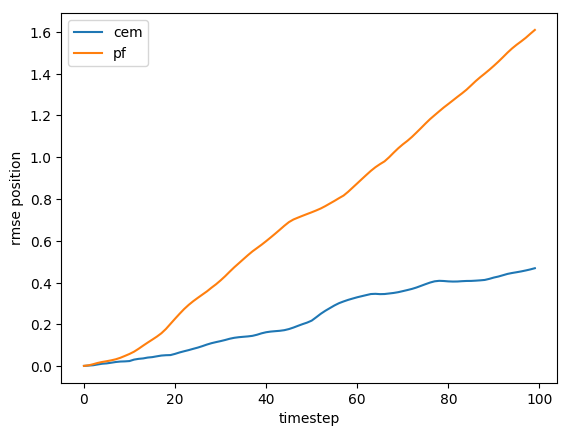

PyObject Text(24.0, 0.5, 'rmse position')

In [19]:
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
rmse_pos_array_cem = estimate_then_evaluate_imitation(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
rmse_pos_array_pf = estimate_then_evaluate_imitation(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
plot(rmse_pos_array_cem,label="cem")
plot(rmse_pos_array_pf,label="pf")
legend()
xlabel("timestep")
ylabel("rmse position")

# Recent Work

In [ ]:
# 5 cars adjacent lanes scenario with 3 parameters
# Parameter wise result plotting with both cem and pf in same plot
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2,:T=>1.5);d2 = Dict(:v_des=>20.0,:σ=>0.3,:T=>1.5);
d3 = Dict(:v_des=>15.0,:σ=>0.,:T=>1.5);d4 = Dict(:v_des=>18.0,:σ=>0.4,:T=>1.5);
d5 = Dict(:v_des=>27.0,:σ=>0.2,:T=>1.5)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.),(:T,0.1,0.1,5.)]
rmse_array_pf = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
rmse_array_cem = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem");
pf_array = combine_array_dicts(rmse_array_pf);
cem_array = combine_array_dicts(rmse_array_cem);
res = combine_exp_results_dicts([:cem,:pf],[cem_array,pf_array])
plot_dict(res)
xlabel("timestep")
ylabel("absolute deviation");

In [ ]:
# 2 cars in the same lane scenario with 3 parameters
# Parameter wise result plotting with both cem and pf in same plot
num_particles = 100
pos_vel_array_1 = [(30.,18.),(10.,12.)]
lane_place_array = [pos_vel_array_1]
num_cars = 2
d1 = Dict(:v_des=>20.0,:σ=>0.1,:T=>1.5);d2 = Dict(:v_des=>10.0,:σ=>0.1,:T=>1.5)
car_particles = [d1,d2]
particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.),(:T,0.1,0.1,5.)]
rmse_array_pf = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
rmse_array_cem = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem");

pf_array = combine_array_dicts(rmse_array_pf);
cem_array = combine_array_dicts(rmse_array_cem);
res = combine_exp_results_dicts([:cem,:pf],[cem_array,pf_array])
plot_dict(res)
xlabel("timestep")
ylabel("absolute deviation");

# Legacy

In [ ]:
# 5 cars adjacent lanes scenario with 2 parameters
# Combines all paramters into one mean error metric and plots that
# Cem and pf appear as different lines on the plot
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
rmse_array_pf = capture_filtering_progress(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
rmse_array_cem = capture_filtering_progress(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
plot(rmse_array_pf,label="particle filter")
plot(rmse_array_cem,label="cross entropy method")
legend()
xlabel("Timestep along true data trajectory")
ylabel("Mean parameter error")

In [ ]:
# 2 cars in the same lane scenario with 2 parameters
num_particles = 100
pos_vel_array_1 = [(30.,15.),(10.,15.)]
lane_place_array = [pos_vel_array_1]
num_cars = 2
d1 = Dict(:v_des=>20.0,:σ=>0.1);d2 = Dict(:v_des=>10.0,:σ=>0.1)
car_particles = [d1,d2]
particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
bucket_array = filter_particles_over_trajectory(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
print_buckets_mean(bucket_array)

In [ ]:
# 5 cars adjacent lanes scenario with 2 parameters
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
bucket_array = filter_particles_over_trajectory(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
print_buckets_mean(bucket_array)

# Visualize

In [ ]:
# Example code to run visualization in your notebook
cam = StaticCamera(VecE2(100.0,0.0), 4.75)
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam, canvas_height=100)
end

# LEARNING AND EXPERIMENTATION

In [ ]:
# LEARNING ABOUT MULTIDIM DISTB
# Test: Generate samples for a 2d distb
d2 = MvNormal(2,2.0) # first arg shows dimension, second shows std dev
qw = rand(d2,6) # Will generate 6 samples i.e. 6 columns

# Test: Fit 2d distribution
dx = Normal()
dy = Normal(2,1.0)
x = rand(dx,100)
y = rand(dy,100)

# Matrix with each column being a sample
# Total columns is total number of samples
# Total rows is number of parameters
# All entries in a row contain value from same param eg:v_des
data_matrix = vcat(x',y')
fit(MvNormal,data_matrix)

In [ ]:
num_samples = 2000
y1 = rand(Normal(10.0,5.0),num_samples)
y2 = rand(Normal(2.0,1.0),num_samples)
plot(1:num_samples,y1)
plot(1:num_samples,y2)

In [ ]:
using StatsPlots

In [ ]:
# Demonstrate the use of StatsPlots plot which will come in useful for distribution plotting
StatsPlots.plot(MvNormal(2,2.),linewidth=4,size=(500,500))

In [ ]:
# See whether sampling from a normal truly results in a normal
num_samples = 5000
y1 = rand(Normal(10.0,5.0),num_samples)
PyPlot.hist(y1)